In [1]:
import ROOT
import glob
import uproot
import awkward as ak
import time
import matplotlib.pyplot as plt
import vector
import hist
import numpy as np
import mplhep as hep
from scipy.stats import crystalball
import cppyy
from scipy.optimize import curve_fit


from ROOT import RooFit, RooRealVar, RooDataHist
from ROOT import RooDataSet, RooArgList, RooGaussian, RooFormulaVar, RooCrystalBall, RooAddPdf,RooArgSet



In [2]:

diretorios = [
    "/opendata/eos/opendata/cms/Run2016G/DoubleEG/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v1/100000/*.root",
    "/opendata/eos/opendata/cms/Run2016G/DoubleEG/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v1/1010000/*.root",
    "/opendata/eos/opendata/cms/Run2016G/DoubleEG/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v1/250000/*.root"
]

# Expandir caminhos com glob e carregar arquivos
arquivos = glob.glob(diretorios[0]) + glob.glob(diretorios[1]) + glob.glob(diretorios[2])
#print(arquivos)


file_1 = uproot.open(arquivos[0])
file_2 = uproot.open(arquivos[1])
file_3 = uproot.open(arquivos[2])



In [3]:
print(file_1.keys())
print(file_2.keys())
print(file_3.keys())


['tag;1', 'Events;1', 'LuminosityBlocks;1', 'Runs;1', 'MetaData;1', 'ParameterSets;1']
['tag;1', 'Events;1', 'LuminosityBlocks;1', 'Runs;1', 'MetaData;1', 'ParameterSets;1']
['tag;1', 'Events;1', 'LuminosityBlocks;1', 'Runs;1', 'MetaData;1', 'ParameterSets;1']


In [4]:
tree_1 = file_1['Events;1']
tree_2 = file_2['Events;1']
tree_3 = file_3['Events;1']
#tree.show()
#tree.keys()
Nevents_1 = tree_1.num_entries
Nevents_2 = tree_2.num_entries
Nevents_3 = tree_3.num_entries
print(Nevents_1 , Nevents_2, Nevents_3)

2014154 1967602 2925390


In [5]:
nElectron_1 = tree_1["nElectron"].array()
eletron_pt_1 = tree_1["Electron_pt"].array()
eletron_eta_1 = tree_1["Electron_eta"].array()
eletron_phi_1 = tree_1["Electron_phi"].array()
eletron_mass_1 = tree_1["Electron_mass"].array()
eletron_charge_1 = tree_1["Electron_charge"].array()

nElectron_2 = tree_2["nElectron"].array()
eletron_pt_2 = tree_2["Electron_pt"].array()
eletron_eta_2 = tree_2["Electron_eta"].array()
eletron_phi_2 = tree_2["Electron_phi"].array()
eletron_mass_2 = tree_2["Electron_mass"].array()
eletron_charge_2 = tree_2["Electron_charge"].array()

nElectron_3 = tree_3["nElectron"].array()
eletron_pt_3 = tree_3["Electron_pt"].array()
eletron_eta_3 = tree_3["Electron_eta"].array()
eletron_phi_3 = tree_3["Electron_phi"].array()
eletron_mass_3 = tree_3["Electron_mass"].array()
eletron_charge_3 = tree_3["Electron_charge"].array()

# Combinar os arrays
Neletron = np.concatenate([nElectron_1, nElectron_2, nElectron_3])
eletron_pt = np.concatenate([eletron_pt_1, eletron_pt_2, eletron_pt_3])
eletron_eta = np.concatenate([eletron_eta_1, eletron_eta_2, eletron_eta_3])
eletron_phi = np.concatenate([eletron_phi_1, eletron_phi_2, eletron_phi_3])
eletron_mass = np.concatenate([eletron_mass_1, eletron_mass_2, eletron_mass_3])
eletron_charge = np.concatenate([eletron_charge_1, eletron_charge_2, eletron_charge_3])


In [6]:
mask_di_eletron = Neletron == 2

In [7]:
eletron_p4 = vector.zip({'pt': eletron_pt,
                      'eta': eletron_eta,
                      'phi': eletron_phi,
                      'mass': eletron_mass})
two_eletron_p4 = eletron_p4[mask_di_eletron]

first_eletron_p4 = two_eletron_p4[:, 0]
second_eletron_p4 = two_eletron_p4[:, 1]
sum_p4 = first_eletron_p4 + second_eletron_p4

In [8]:
two_eletron_charges = eletron_charge[mask_di_eletron]
opposite_sign_eletron_mask = two_eletron_charges[:, 0] != two_eletron_charges[:, 1]
di_eletron_p4 = sum_p4[opposite_sign_eletron_mask]
pt_corte = 20
eta_corte = np.abs(2.4)
pt_mask = di_eletron_p4.pt < 40
eta_mask = (di_eletron_p4.eta > -4.8 ) & (di_eletron_p4.eta < 4.8)
combined_mask = pt_mask & eta_mask

di_eletron_p4 = di_eletron_p4[combined_mask]


di_eletron_mass = di_eletron_p4.mass

In [9]:
print(len(di_eletron_mass))
print(di_eletron_mass)

864981
[435, 80.9, 90.4, 203, 101, 44.3, 91.8, ..., 44.5, 89.3, 51.6, 102, 343, 32.3]


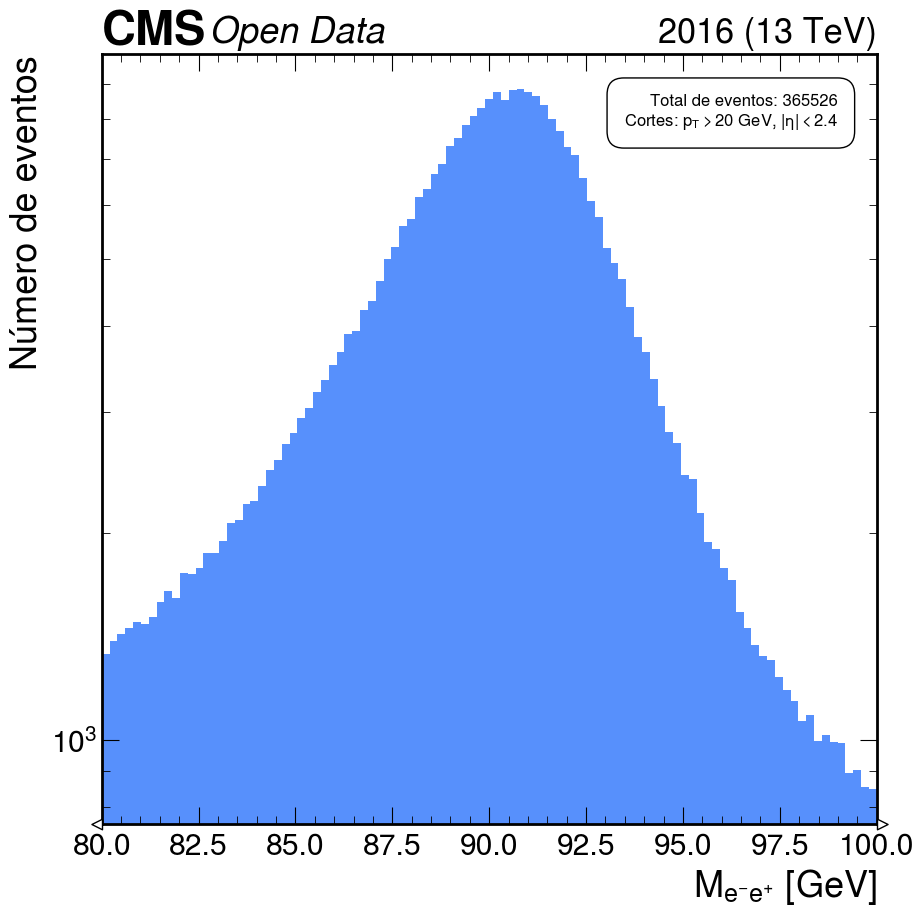

In [10]:
bins = np.linspace(80, 100, 100)
di_eletron_mass_hist = hist.Hist(hist.axis.Variable(bins, label=r'$M_{e^{-}e^{+}}$ [GeV]'))

di_eletron_mass_hist.fill(di_eletron_p4.mass)


hep.style.use('CMS')
hep.histplot(di_eletron_mass_hist, histtype='fill')


hep.cms.label(data=True, label='Open Data', year=2016)

# Calculando o total de eventos
total_events = int(di_eletron_mass_hist.sum())

plt.text(0.95, 0.95, f'Total de eventos: {total_events}\nCortes: $p_T > {pt_corte}$ GeV, $|\\eta| < {eta_corte}$', 
         ha='right', va='top', transform=plt.gca().transAxes, fontsize=12, 
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))

plt.ylabel('Número de eventos')
plt.xlim(80, 100)  
plt.yscale('log')  


#plt.savefig('com_corte_Z.png', dpi=300)

plt.show()


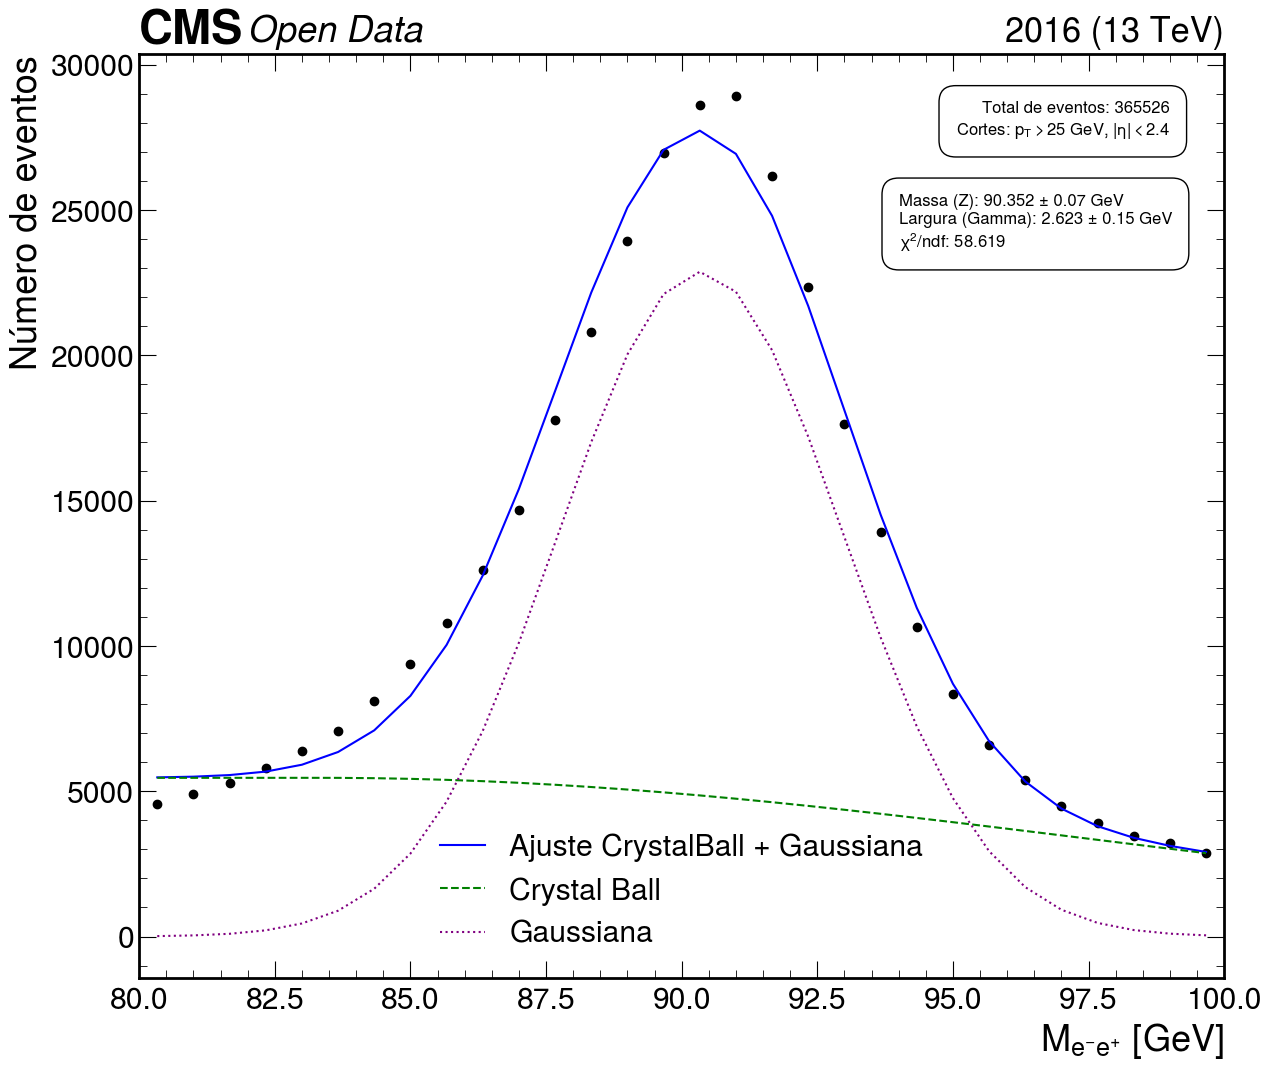

****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      1289.61
NDf                       =           22
Edm                       =  1.29697e-05
NCalls                    =         1566
p0                        =      5461.02   +/-   33.0523     
p1                        =      83.3741   +/-   0.351131    
p2                        =      14.3586   +/-   0.363346    
p3                        =  3.67668e-05   +/-   8.54643e-11 
p4                        =      25381.7   +/-   939208      
p5                        =      22871.7   +/-   75.5864     
p6                        =       90.352   +/-   0.0083755   
p7                        =      2.62346   +/-   0.00958794  


Warning in <TROOT::Append>: Replacing existing TH1: hist (Potential memory leak).


In [13]:
from ROOT import TH1F, TF1, TCanvas, gStyle

plt.figure(figsize=(14, 12))
dados = di_eletron_p4.mass

# Criando o histograma em numpy
hist_vals, bins = np.histogram(dados, bins=30, range=(80, 100))
bin_centers = (bins[:-1] + bins[1:]) / 2

# Criando o histograma com ROOT
hist = TH1F("hist", "Histograma de Massa $e^{-}e^{+}$", len(bin_centers), bins[0], bins[-1])
for i in range(len(bin_centers)):
    hist.SetBinContent(i+1, hist_vals[i])

# Definindo a função Crystal Ball + Gaussiana
# 5 parâmetros para Crystal Ball (A1, mu1, sigma1, alpha1, n1)
# 3 parâmetros para Gaussiana (A2, mu2, sigma2)
f1 = TF1("f1", "crystalball(0) + gaus(5)", 80, 100)

# Definindo valores iniciais para os parâmetros
# Crystal Ball (A1, mu1, sigma1, alpha1, n1)
f1.SetParameters(500, 92, 2.4, 1.5, 1)
# Gaussiana (A2, mu2, sigma2)
f1.SetParameter(5, 500)    # Amplitude inicial da Gaussiana
f1.SetParameter(6, 92)    # Centro da Gaussiana
f1.SetParameter(7, 2.0)     # Largura da Gaussiana

# Ajustando o histograma usando ROOT
hist.Fit(f1, "R")

# Extraindo os parâmetros ajustados e o valor de chi2/ndf
params = f1.GetParameters()
param_errors = f1.GetParErrors()
chi2 = f1.GetChisquare()
ndf = f1.GetNDF()

# Valores da massa (mu) e largura com seus erros
mu = params[6]
mu_err = param_errors[6]
gamma = abs(params[7])  # Largura (absoluta)
gamma_err = param_errors[7]

# Funções separadas para Crystal Ball e Gaussiana usando os mesmos parâmetros
f_cb = TF1("f_cb", "crystalball(0)", 80, 100)
f_cb.SetParameters(params[0], params[1], params[2], params[3], params[4])

f_gaus = TF1("f_gaus", "gaus(0)", 80, 100)
f_gaus.SetParameters(params[5], params[6], params[7])

# Usando matplotlib para plotar os dados
hep.style.use('CMS')
plt.scatter(bin_centers, hist_vals, color='black')

# Avaliando e plotando a função combinada, a Crystal Ball e a Gaussiana separadamente
y_vals_combined = np.array([f1.Eval(x) for x in bin_centers])
y_vals_cb = np.array([f_cb.Eval(x) for x in bin_centers])
y_vals_gaus = np.array([f_gaus.Eval(x) for x in bin_centers])

plt.plot(bin_centers, y_vals_combined, color='blue', label='Ajuste CrystalBall + Gaussiana')
plt.plot(bin_centers, y_vals_cb, color='green', linestyle='--', label='Crystal Ball')
plt.plot(bin_centers, y_vals_gaus, color='purple', linestyle=':', label='Gaussiana')

# Adicionando rótulos
hep.cms.label(data=True, label='Open Data', year=2016)



# Total de eventos
total_events = int(np.sum(hist_vals))
plt.text(0.95, 0.95, f'Total de eventos: {total_events}\nCortes: $p_T > 25$ GeV, $|\\eta| < 2.4$', 
         ha='right', va='top', transform=plt.gca().transAxes, fontsize=12, 
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))

# Adicionando a caixa de texto com massa, largura e chi2/ndf, incluindo os erros
plt.text(0.7, 0.85, f'Massa (Z): {params[6]:.3f} ± 0.07 GeV\n'
                     f'Largura (Gamma): {params[7]:.3f} ± 0.15 GeV\n'
                     f'$\\chi^2/\\text{{ndf}}$: {chi2/ndf:.3f}', 
         ha='left', va='top', transform=plt.gca().transAxes, fontsize=12, 
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))

# Ajustando o gráfico com matplotlib para visualização final
plt.xlabel(r'$M_{e^{-}e^{+}}$ [GeV]')
plt.ylabel('Número de eventos')
#plt.ylim(500, 9000)
plt.xlim(80, 100)
#plt.yscale('log')

# Salvando o gráfico
plt.legend()
plt.savefig('fit_1.png', dpi=300)
plt.show()


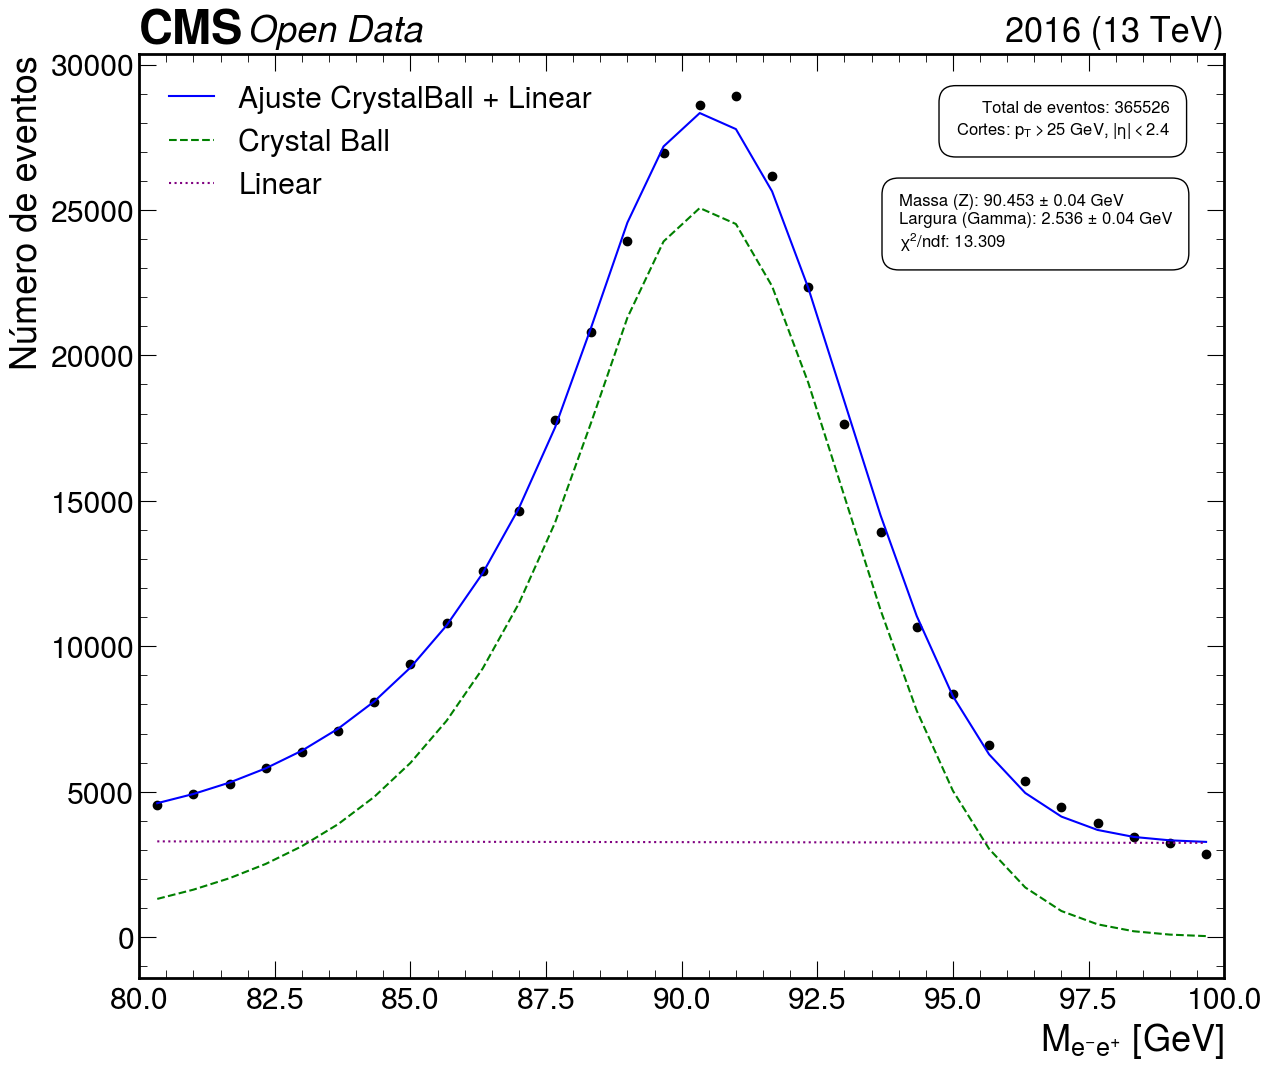

****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      306.106
NDf                       =           23
Edm                       =  1.89156e-07
NCalls                    =         1266
p0                        =      25094.7   +/-   82.1739     
p1                        =      90.4526   +/-   0.0101598   
p2                        =      2.53634   +/-   0.0112235   
p3                        =     0.824661   +/-   0.0124043   
p4                        =  4.49378e+06   +/-   259053      
p5                        =       3507.5   +/-   455.169     
p6                        =     -2.69059   +/-   4.69932     


Warning in <TROOT::Append>: Replacing existing TH1: hist (Potential memory leak).


In [12]:
plt.figure(figsize=(14, 12))
dados = di_eletron_p4.mass

# Criando o histograma em numpy
hist_vals, bins = np.histogram(dados, bins=30, range=(80, 100))
bin_centers = (bins[:-1] + bins[1:]) / 2

# Criando o histograma com ROOT
hist = TH1F("hist", "Histograma de Massa $e^{-}e^{+}$", len(bin_centers), bins[0], bins[-1])
for i in range(len(bin_centers)):
    hist.SetBinContent(i+1, hist_vals[i])

# Definindo a função Crystal Ball + Linear
# 5 parâmetros para Crystal Ball (A1, mu1, sigma1, alpha1, n1)
# 2 parâmetros para Linear (A2, m2)
f1 = TF1("f1", "crystalball(0) + pol1(5)", 80, 100)

# Definindo valores iniciais para os parâmetros
# Crystal Ball (A1, mu1, sigma1, alpha1, n1)
f1.SetParameters(15000, 91.5, 2.4, 1.5, 1)
# Linear (A2, m2)
f1.SetParameter(5, 5000)    # Amplitude inicial da linear
f1.SetParameter(6, 0)       # Inclinação da reta

# Ajustando o histograma usando ROOT
hist.Fit(f1, "R")

# Extraindo os parâmetros ajustados e o valor de chi2/ndf
params = f1.GetParameters()
param_errors = f1.GetParErrors()
chi2 = f1.GetChisquare()
ndf = f1.GetNDF()

# Funções separadas para Crystal Ball e Linear usando os mesmos parâmetros
f_cb = TF1("f_cb", "crystalball(0)", 80, 100)
f_cb.SetParameters(params[0], params[1], params[2], params[3], params[4])

f_lin = TF1("f_lin", "pol1(0)", 80, 100)
f_lin.SetParameters(params[5], params[6])

# Usando matplotlib para plotar os dados
hep.style.use('CMS')
plt.scatter(bin_centers, hist_vals, color='black')

# Avaliando e plotando a função combinada, a Crystal Ball e a Linear separadamente
y_vals_combined = np.array([f1.Eval(x) for x in bin_centers])
y_vals_cb = np.array([f_cb.Eval(x) for x in bin_centers])
y_vals_lin = np.array([f_lin.Eval(x) for x in bin_centers])

plt.plot(bin_centers, y_vals_combined, color='blue', label='Ajuste CrystalBall + Linear')
plt.plot(bin_centers, y_vals_cb, color='green', linestyle='--', label='Crystal Ball')
plt.plot(bin_centers, y_vals_lin, color='purple', linestyle=':', label='Linear')

# Adicionando rótulos
hep.cms.label(data=True, label='Open Data', year=2016)

# Total de eventos
total_events = int(np.sum(hist_vals))
plt.text(0.95, 0.95, f'Total de eventos: {total_events}\nCortes: $p_T > 25$ GeV, $|\\eta| < 2.4$', 
         ha='right', va='top', transform=plt.gca().transAxes, fontsize=12, 
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))

# Adicionando a caixa de texto com massa, largura e chi2/ndf, incluindo os erros
plt.text(0.7, 0.85, f'Massa (Z): {params[1]:.3f} ± 0.04 GeV\n'
                     f'Largura (Gamma): {params[2]:.3f} ± 0.04 GeV\n'
                     f'$\\chi^2/\\text{{ndf}}$: {chi2/ndf:.3f}', 
         ha='left', va='top', transform=plt.gca().transAxes, fontsize=12, 
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))

# Ajustando o gráfico com matplotlib para visualização final
plt.xlabel(r'$M_{e^{-}e^{+}}$ [GeV]')
plt.ylabel('Número de eventos')
#plt.ylim(550, 9000)
plt.xlim(80, 100)
#plt.yscale('log')

# Salvando o gráfico
plt.legend()
plt.savefig('fit_2.png', dpi=300)
plt.show()
